In [51]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [52]:

data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)


In [53]:
data.columns

Index(['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc',
       'cadiovascular_current', 'bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [54]:
data.shape

(4489, 25)

In [55]:
site_id = 1
data = data[(data['site'] == site_id) & (data['age'] <= 65) & (data['age'] >= 40)].copy()

In [73]:
data.loc[:,['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']].shape

(1753, 21)

In [72]:
data.iloc[:,4:].shape

(1753, 21)

In [74]:
X = data.iloc[:,4:]
y1 = data.loc[:,'htn_jnc7_qc']

In [57]:
data['partnership_status_c_qc'].value_counts(normalize=True)

1    0.663434
2    0.254421
0    0.082145
Name: partnership_status_c_qc, dtype: float64

In [58]:
dff = data.mask(data == -999, np.nan).copy()

[IterativeImputer] Early stopping criterion not reached.


<Axes: ylabel='Density'>

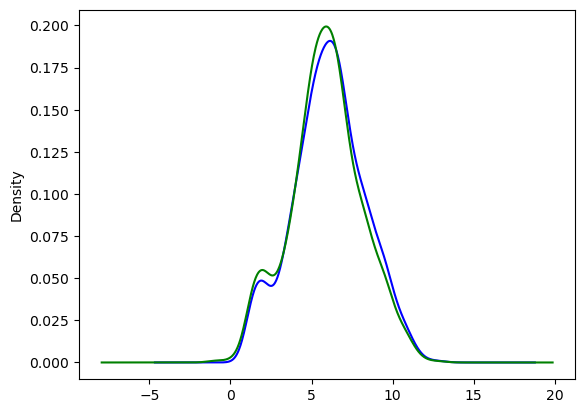

In [60]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff)
train_t = imputer.transform(dff)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff['visceral_fat_qc'].plot(kind='kde', ax=ax, color='blue')
treated['visceral_fat_qc'].plot(kind='kde', ax=ax, color='green')

In [ ]:
# dff2 = data.mask(data == -999, np.nan)
# dff2.isnull().sum()/dff2.shape[0]

In [75]:
predictors = data.iloc[:,4:].columns

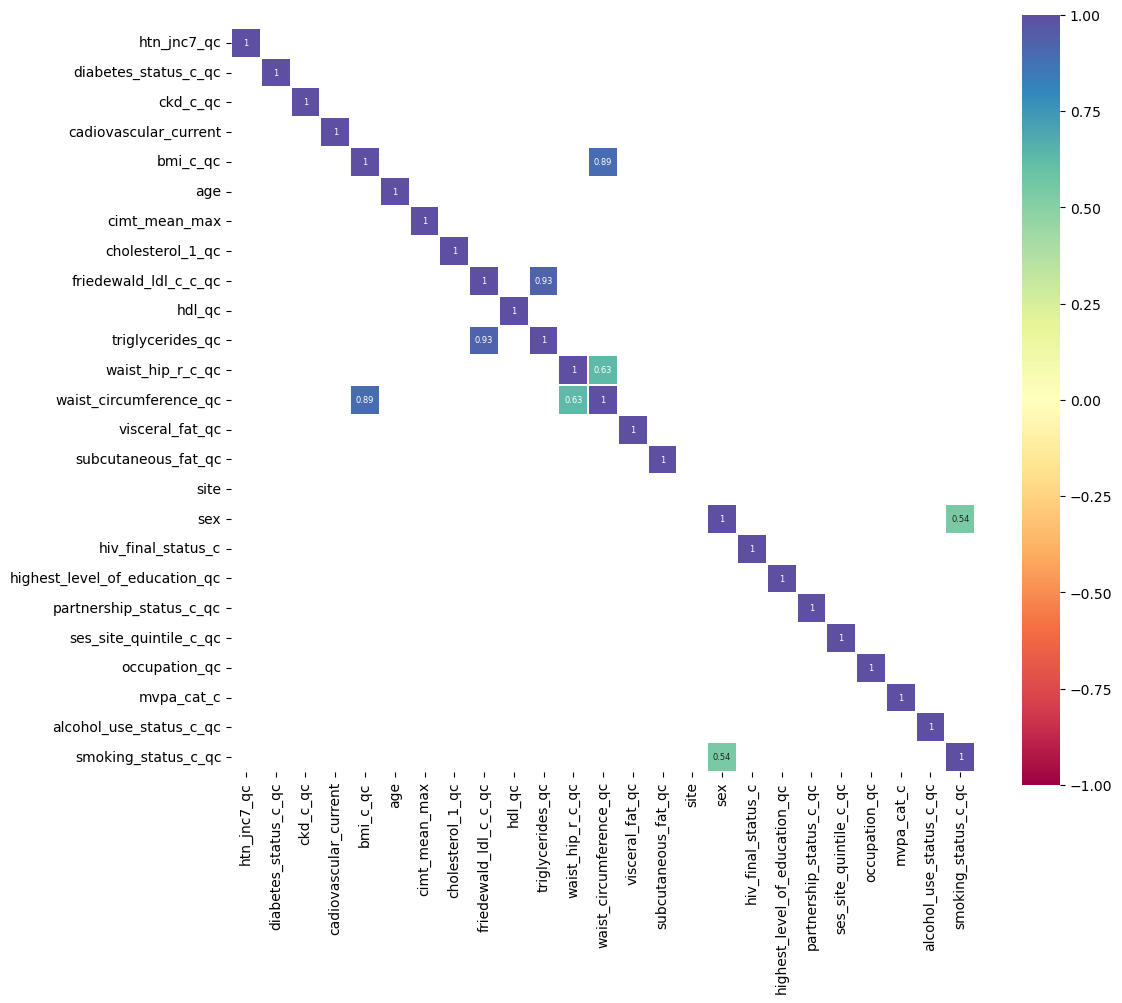

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

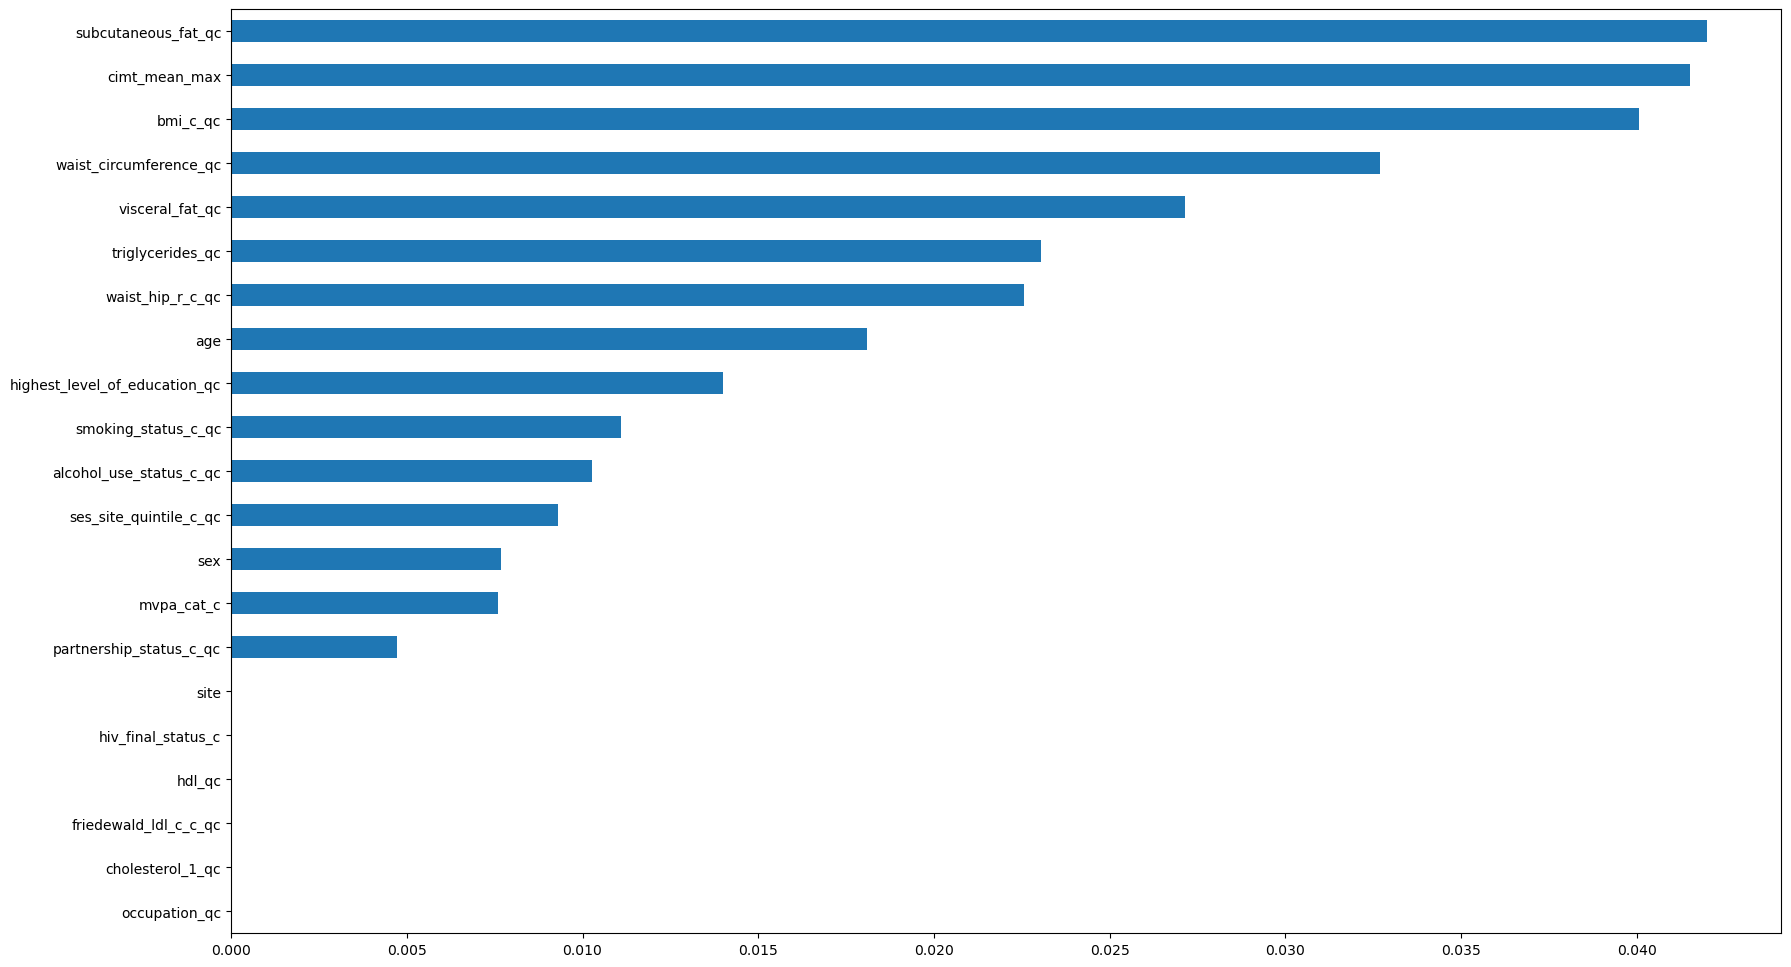

In [77]:
from sklearn.feature_selection import mutual_info_classif
## First, treat missing values before execution
# X = treated.values
X = treated[predictors].values
y = y1
importance = mutual_info_classif(X,y)
# feat_importance = pd.Series(importance, treated.columns[0:len(data.columns)-1])
feat_importance = pd.Series(importance, treated[predictors].columns[0:len(treated[predictors].columns)-0])
ff = feat_importance.sort_values(ascending=True)
plt.figure(figsize=(20,12))
ff.plot(kind='barh')
plt.show()